In [1]:
#this is where single run functions such as creating the flat pickle file(flat database) and loading aligning spectra
from pipeline import import_aligning_spectra
from NRES_SHK_Pipeline import create_flat_dict_file

#Project folder directory on your computer
homePath = 'D:/My Documents/Coding Projects/nreshk/'

#required paths for pipeline, try not to change ever
dataPath = homePath + 'data/'
outputPath = homePath + 'output/'
flatPath = dataPath + 'flats/'
flatPickle = "flatDict.pkl"

create_flat_dict_file(flatPath,flatPickle)

#need this in memory for the following wrapper
#TODO maybe a better way to do this without lugging the lab spectra around every install
lab = import_aligning_spectra(dataPath+ 'LabSpectra/', resolution=0)#,res*10)
print('done')

done


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
HD 100180 already has output
HD 114710 already has output
HD 115383 already has output
HD 115404 already has output
HD 120136 already has output
HD 12235 already has output
HD 126053 already has output
HD 136202 already has output
HD 149661 already has output
HD 152391 already has output
HD 154417 already has output
HD 165341A already has output
HD 17051 already has output
HD 176051 already has output
HD 182101 already has output
HD 1835 already has output
HD 187691 already has output
HD 190406 already has output
HD 194012 already has output
HD 20630 already has output
HD 206860 already has output
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Running pipeline on HD 22049
-------------------------------------------------------------------------------
bad correlation: 1.082127334937545
MJD: 58761.9901174 and decYr 2019.76161676 w/ shk: 0.45097556300128194 and offset:0.

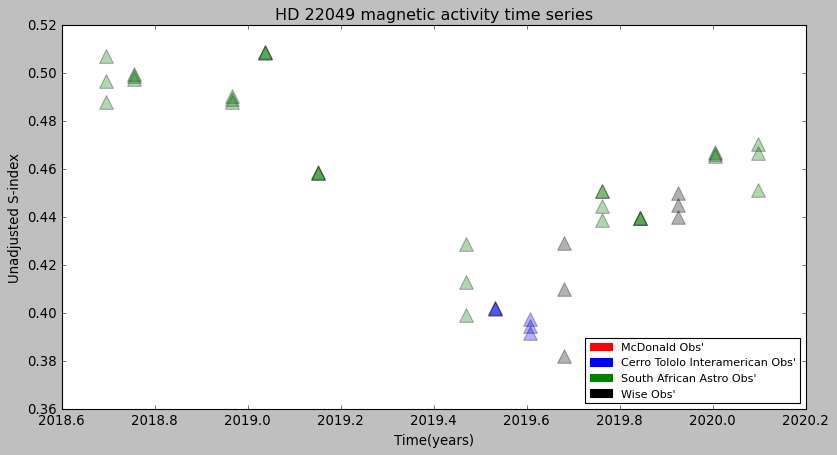

HD 26913 already has output
HD 30495 already has output
HD 37394 already has output
HD 43587 already has output
HD 49933 already has output
HD 75332 already has output
HD 76151 already has output
HD 78366 already has output
HD 82443 already has output
HD 82885 already has output
HD 88737 already has output
HD 98230B already has output
bad folder 'flats'
bad folder 'LabSpectra'
[58330.3596906, 58330.3634695, 58553.7527935, 58553.7479017, 58272.4211262, 58272.4248934, 58354.2323109, 58354.2381758, 58331.3384727, 58331.3384727, 58331.342243, 58354.3656538, 58354.3715002, 58434.3511998, 58434.3561144, 58354.3715002, 58354.3656538, 58331.342243, 58331.3384727, 58331.342243, 58354.3656538, 58354.3715002, 58434.3511998, 58434.3561144]


In [34]:
%load_ext autoreload
%autoreload


#from matplotlib.backends.backend_pdf import PdfPages
import NRES_SHK_Pipeline as nresshk
import pipeline_testing as t

flatDict = nresshk.NRES_SHK_MkFlat(flatPath,flatPickle)


#MJD dates known to be bad TODO better feature use, maybe not w/ mjd
bad = [58330.3596906, 58330.3634695, 58553.7527935, 58553.7479017, 58272.4211262, 58272.4248934, 58354.2323109, 58354.2381758, 58331.3384727, 58331.3384727, 58331.342243, 58354.3656538, 58354.3715002, 58434.3511998, 58434.3561144,58354.3715002,58354.3656538,58331.342243]

#a list of stars we MUST run, regardless of if there is already output
forceRun = ["22049"]#["76151","22049"]
    
#debug mode
#verbose debug
#file output
#etc
debugMode = 0#currently N/A

#output mode
#0 - all output 
#1 - only star 
#2 - only time series
#etc
pdfMode = 0#currently N/A`
#s
#TODO impement
#if using radial velocity to align must have dict of star HD's and their rv
alignmentDict = []#currently N/A

#t.test_daily_data_sum()

nresshk.NRES_SHK_Pipeline(dataPath,outputPath,flatDict,lab,bad,forceRun)

